# Read ILC weights and residuals from the below folder.

### Weights and residuals are provided for MV, tSZ-free, and CIB-free CMB/kSZ ILC maps.

#### File locaiton: publish/data/ilc_weights_residuals.npy

In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
import numpy as np, sys, os, scipy as sc, warnings
sys.path.append('modules')
import tools
import matplotlib.cbook
import scipy.ndimage as ndimage
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

#%pylab notebook
%matplotlib inline
from pylab import *


In [4]:
rcParams['figure.dpi'] = 150
rcParams['figure.facecolor'] = 'white'


In [117]:
#read file
which_fg_model = 'agora'

fname = 'publish/data/ilc_weights_residuals_%s_fg_model.npy' %(which_fg_model)
ilc_dict = np.load(fname, allow_pickle = True).item()
print(ilc_dict.keys())

#different types of ILC considered
ilc_keyname_arr = ilc_dict['ilc_keyname_arr']
print(ilc_keyname_arr)

#ILC weights
weights_dict = ilc_dict['weights']
print(weights_dict.keys())

#total ILC residuals
total_ilc_residuals_dict = ilc_dict['total_ilc_residuals']
print(total_ilc_residuals_dict.keys())

#CIB, tSZ, and CIB+tSZ
cib_ilc_residuals_dict = ilc_dict['cib_residuals']
tsz_ilc_residuals_dict = ilc_dict['tsz_residuals']
cib_plus_tsz_ilc_residuals_dict = ilc_dict['cib_plus_tsz_residuals']
radio_ilc_residuals_dict = ilc_dict['radio_residuals']
noise_ilc_residuals_dict = ilc_dict['noise_residuals']
print(cib_ilc_residuals_dict['s4_wide'].keys())

if (1): #with CCAT-prime
    fname_withccatp = 'publish/data/ilc_weights_residuals_%s_fg_model_withccatphfnoisescaledby5.0.npy' %(which_fg_model)
    ilc_dict_withccatp = np.load(fname_withccatp, allow_pickle = True).item()
    cib_plus_tsz_ilc_residuals_dict_withccatp = ilc_dict_withccatp['cib_plus_tsz_residuals']
    print(ilc_dict_withccatp.keys())


#el range
els = ilc_dict['el']

#smooth
perform_smoothing = True #just make the residuals smoother
if perform_smoothing:
    delta_el = 1
else:
    delta_el = 10

dict_keys(['weights', 'total_ilc_residuals', 'cib_plus_tsz_residuals', 'cib_residuals', 'tsz_residuals', 'noise_residuals', 'radio_residuals', 'nl_TP_dict', 'cl_signal_plus_noise', 'ilc_keyname_arr', 'el'])
['mv' 'tszfree' 'cibfree' 'mvxcibfree' 'mvxtszfree' 'tszfreexcibfree']
dict_keys(['s4_wide', 's4_deep', 'spt3g', 'spt4', 'so_baseline', 'so_goal'])
dict_keys(['s4_wide', 's4_deep', 'spt3g', 'spt4', 'so_baseline', 'so_goal'])
dict_keys(['mv', 'tszfree', 'cibfree', 'mvxcibfree', 'mvxtszfree', 'tszfreexcibfree'])
dict_keys(['weights', 'total_ilc_residuals', 'cib_plus_tsz_residuals', 'cib_residuals', 'tsz_residuals', 'nl_TP_dict', 'cl_signal_plus_noise', 'ilc_keyname_arr', 'el'])


In [133]:
#experiment names and colours
def get_colours(no_of_colors_reqd, cmap = cm.RdYlBu):    
    colorarr = [cmap(int(d)) for d in np.linspace(0, 255, no_of_colors_reqd)]
    #colorarr[2] = 'goldenrod'
    return colorarr

exp_specs_dict = {'s4_wide': ['S4-Wide', 'black'], 
                  's4_deep': ['S4-Ultra Deep', 'darkred'], 
                  'spt3g': ['SPT-3G', 'darkgreen'],
                  'spt4': ['SPT-3G+SPT-4', 'goldenrod'],
                  'so_baseline': ['SO-Baseline', 'royalblue'],
                  'so_goal': ['SO-Goal', 'darkorange']}

'''
colorarr = get_colours( len(exp_specs_dict) )
for cntr, expname in enumerate( exp_specs_dict ):
    exp_specs_dict[expname][1] = colorarr[cntr]
'''

#experiment ordering
exparr = ['spt3g', 'spt4', 'so_baseline', 'so_goal', 's4_wide', 's4_deep']

#ILC keynames
ilc_keyname_dict = {'mv':'MV', 'tszfree': 'tSZ-free', 'cibfree': 'CIB-free'}

#CMB spectrum
camb_fname = 'publish/data/cmb_cl_planck_2015_lensedCls.dat'
el_camb = np.loadtxt(camb_fname, usecols = [0])
dl_camb = np.loadtxt(camb_fname, usecols = [1,2,3,4])
Tcmb = 2.73 #Kelvin
cl_camb = ( Tcmb**2. * dl_camb * 2 * np.pi ) / ( el_camb[:,None] * (el_camb[:,None] + 1) )
cl_camb *= 1e12
cl_TT, cl_EE, cl_BB, cl_TE = cl_camb.T

dl_fac_camb = el_camb * (el_camb+1)/2/np.pi


In [134]:
def fn_format_axis(ax,fx,fy):
    for label in ax.get_xticklabels(): label.set_fontsize(fx)
    for label in ax.get_yticklabels(): label.set_fontsize(fy)
    if (0):
        import matplotlib.ticker as ticker
        ax.xaxis.set_major_locator(ticker.MaxNLocator(4))
        ax.xaxis.set_minor_locator(ticker.MaNLocator(4))
        ax.yaxis.set_major_locator(ticker.MaNLocator(4))
        ax.yaxis.set_minor_locator(ticker.MaNLocator(4))
    return ax

# Figure 1 of the paper - MV ILC residuals for different experiments.

<Figure size 900x600 with 0 Axes>

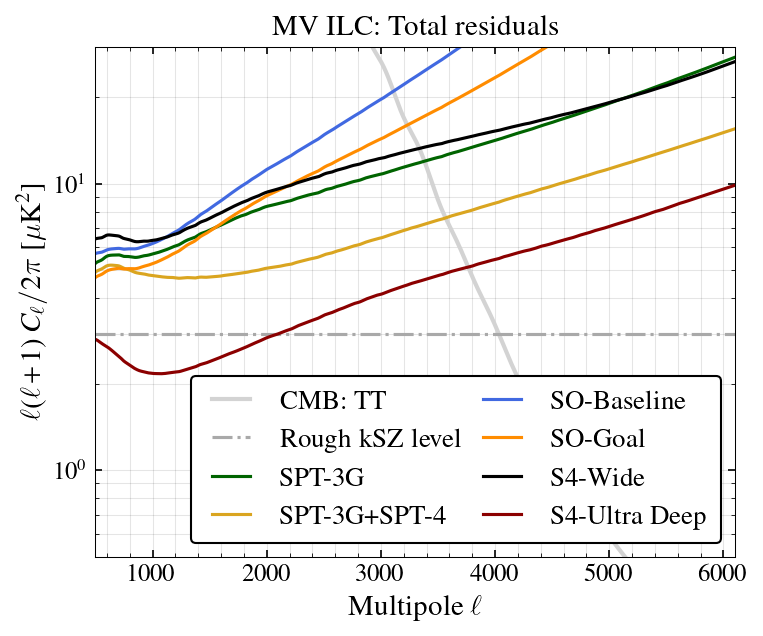

In [141]:
#MV-ILC total residuals for different experiments
reqd_ilc_keyname = 'mv'

#el range
els = ilc_dict['el']

clf()
figure(figsize = (5.5, 4.5))
fsval = 14
ax = subplot(111, yscale='log')
dl_fac = els * (els+1)/2/np.pi #show plot in D_l rather than C_l

#CMB and expected kSZ level
plot(el_camb, dl_fac_camb * cl_TT, lw = 2., color = 'lightgray', label = r'CMB: TT')
axhline(3., lw = 1.5, color = 'darkgray', ls ='-.', label = r'Rough kSZ level')

for expname in exparr: #total_ilc_residuals_dict:
    els, total_ilc_residual_mv = total_ilc_residuals_dict[expname][reqd_ilc_keyname]
    if perform_smoothing:
        total_ilc_residual_mv=ndimage.filters.gaussian_filter1d(total_ilc_residual_mv,sigma=20)
    expname_str, colorval = exp_specs_dict[expname]
    lwval = 1.5

    if (1): #take mean for a certain \ell_range
        binned_els = np.arange(0, max(els), delta_el)
        binned_dl_fac = binned_els * (binned_els+1)/2/np.pi
        binned_total_ilc_residual_mv = np.interp( binned_els, els, total_ilc_residual_mv)
        plot(binned_els, binned_dl_fac * binned_total_ilc_residual_mv, lw = lwval, color = colorval, label = r'%s' %(expname_str))
    else:
        plot(els, dl_fac * total_ilc_residual_mv, lw = lwval, color = colorval, label = r'%s' %(expname_str))

#title
title_str = r'%s ILC: Total residuals' %(ilc_keyname_dict[reqd_ilc_keyname])
title(title_str, fontsize = fsval)

#legend
legend(loc = 4, fontsize = fsval-1, ncol = 2, columnspacing = .5, framealpha=1.)#, handlelength = 1.5)

#labels
xlabel(r'Multipole $\ell$', fontsize = fsval)
#ylabel(r'D$_{\ell}$ [$\mu$K$^{2}$]', fontsize = fsval)
ylabel(r'$\ell(\ell+1)\ C_{\ell} / 2\pi$ [$\mu$K$^{2}$]', fontsize = fsval)
fn_format_axis(ax,fsval-2,fsval-2)

#limits
#xmin, xmax = 1000., 5000.
#ymin, ymax = 0.5, 50.
xmin, xmax = 500., 6100.
ymin, ymax = .5, 30.
xlim(xmin, xmax); ylim(ymin, ymax)

#grid
#grid(which = 'major', axis = 'both', lw = 0.1, color = 'black')
#grid(which = 'minor', axis = 'both', lw = 0.05, color = 'black')
grid(True, which='both', axis = 'both', lw = 0.5, alpha = 0.1)

#save
plname = 'plots/ilc_residuals_mv.pdf'
savefig(plname, dpi = 200.)
show()

# Figure 2 of the paper - CIB/tSZ ILC residuals in the MV map for different experiments.

<Figure size 900x600 with 0 Axes>

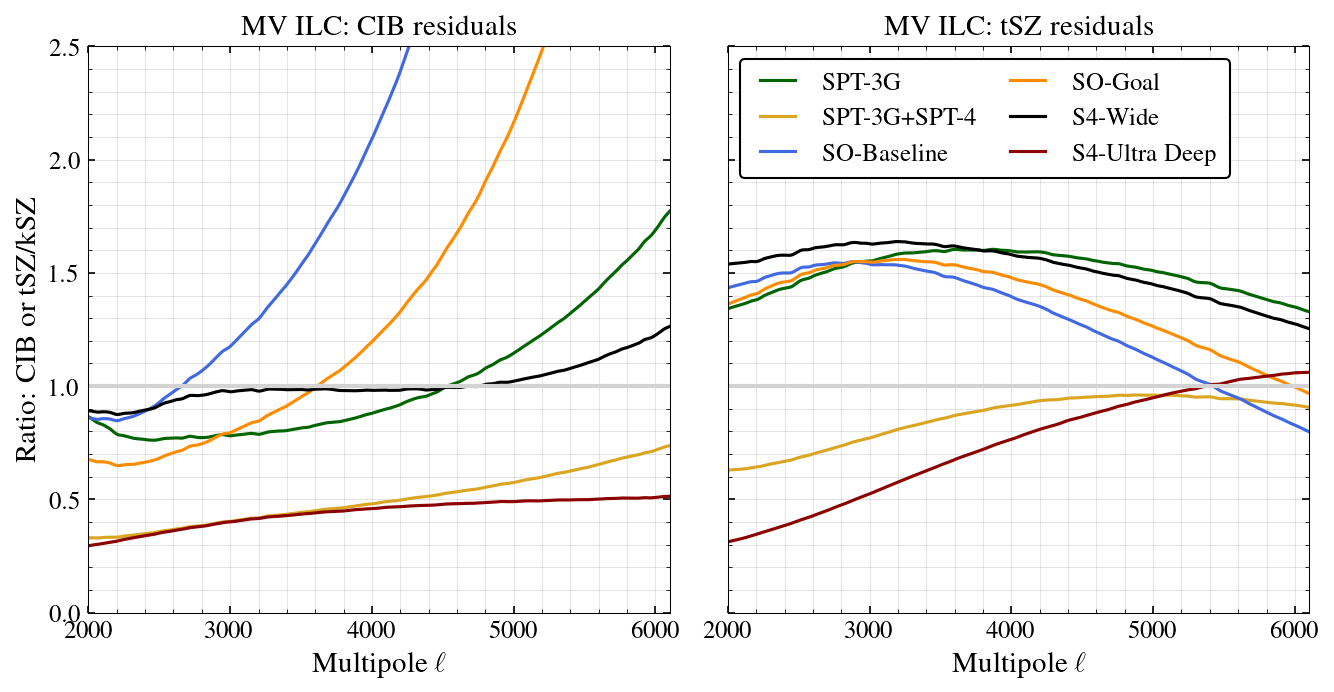

In [164]:
#MV-ILC CIB and tSZ residuals for different experiments
reqd_ilc_keyname = 'mv'
ratio_plot = True #False

#el range
els = ilc_dict['el']

clf()
fig=figure(figsize = (10.5, 5.))
subplots_adjust(wspace = 0.1)
fsval = 14
for cntr, comp in enumerate( ['CIB', 'tSZ'] ):
    if ratio_plot:
        ax = subplot(1, 2, cntr+1)
    else:
        ax = subplot(1, 2, cntr+1, yscale='log')
    for expname in exparr:#total_ilc_residuals_dict:
        expname_str, colorval = exp_specs_dict[expname]
        cib_ilc_residual_mv = cib_ilc_residuals_dict[expname][reqd_ilc_keyname]
        tsz_ilc_residual_mv = tsz_ilc_residuals_dict[expname][reqd_ilc_keyname]
        
        if perform_smoothing:
            cib_ilc_residual_mv=ndimage.filters.gaussian_filter1d(cib_ilc_residual_mv,sigma=25)
            tsz_ilc_residual_mv=ndimage.filters.gaussian_filter1d(tsz_ilc_residual_mv,sigma=25)
            lwval = 1.5
        else:
            lwval = 1.

        if (1): #take mean for a certain \ell_range
            ##delta_el = 200
            binned_els = np.arange(0, max(els)+100, delta_el)
            binned_dl_fac = binned_els * (binned_els+1)/2/np.pi
            cib_ilc_residual_mv = np.interp( binned_els, els, cib_ilc_residual_mv)
            tsz_ilc_residual_mv = np.interp( binned_els, els, tsz_ilc_residual_mv)
            dl_fac = binned_els * (binned_els+1)/2/np.pi #show plot in D_l rather than C_l
            binned_dl_ksz = np.tile(3., len(binned_els))
            cl_ksz = binned_dl_ksz / dl_fac
            els_to_plot = np.copy( binned_els )
        else:
            dl_ksz = np.tile(3., len(els))
            cl_ksz = dl_ksz / dl_fac
            els_to_plot = np.copy( els )
            

        if ratio_plot:
            if comp == 'CIB':
                plot(els_to_plot, cib_ilc_residual_mv/cl_ksz, lw=lwval, color = colorval, ls = '-')
            elif comp == 'tSZ':
                plot(els_to_plot, tsz_ilc_residual_mv/cl_ksz, lw=lwval, color = colorval, ls = '-', label = r'%s' %(expname_str))
        else:
            if comp == 'CIB':
                plot(els_to_plot, dl_fac * cib_ilc_residual_mv, lw=lwval, color = colorval, ls = '-')#, label = r'\textsc{%s}' %(expname_str))
            elif comp == 'tSZ':
                plot(els_to_plot, dl_fac * tsz_ilc_residual_mv, lw=lwval, color = colorval, ls = '-')

    #title
    title_str = r'%s ILC: %s residuals' %(ilc_keyname_dict[reqd_ilc_keyname], comp)
    title(title_str, fontsize = fsval)

    #labels
    xlabel(r'Multipole $\ell$', fontsize = fsval)
    fn_format_axis(ax,fsval-2,fsval-2)
    
    if (1): #legend
        if comp == 'tSZ':
            legend(loc = 2, fontsize = fsval-2, ncol = 2, columnspacing = 1., framealpha=1.)


    #limits
    #xmin, xmax = 500., 5500.
    xmin, xmax = 2000., 6100.
    if ratio_plot:
        axhline(1., lw = 2., color = 'lightgray')
        ymin, ymax = 0., 2.5
        ylab = r'Ratio: {\rm CIB or tSZ/kSZ}'
    else:
        axhline(3., lw = 0.5)
        ymin, ymax = 0.1, 2e2
        ylab=r'$\ell(\ell+1)\ C_{\ell} / 2\pi$ [$\mu$K$^{2}$]'

    if cntr == 0:
        ylabel(ylab, fontsize = fsval)
    else:
         setp(ax.get_yticklabels(), visible=False)        
    xlim(xmin, xmax); ylim(ymin, ymax)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=5))

    #grid
    #grid(which = 'major', axis = 'both', lw = 0.1, color = 'black')
    #grid(which = 'minor', axis = 'both', lw = 0.05, color = 'black')
    grid(True, which='both', axis = 'both', lw = 0.5, alpha = 0.1)

if (0): #add legend
    xloc, yloc = 0.1, -.07
    w, h = 0.7, 0.1
    cax = fig.add_axes([xloc, yloc, w, h])
    for expname in total_ilc_residuals_dict:
        expname_str, colorval = exp_specs_dict[expname]
        plot([], [], color = colorval, lw = lwval, label = r'\textsc{%s}' %(expname_str))
    legend(loc = 1, fontsize = fsval, ncol = 3, columnspacing=1., framealpha=0.)
    axis('off')
#save
plname = 'plots/ilc_cib_tsz_residuals_mv.pdf'
savefig(plname, dpi = 200.)
show()

# Figure 3 of the paper - CIB+tSZ residuals in the S4-Wide CMB map for different ILC estimators.

<Figure size 900x600 with 0 Axes>

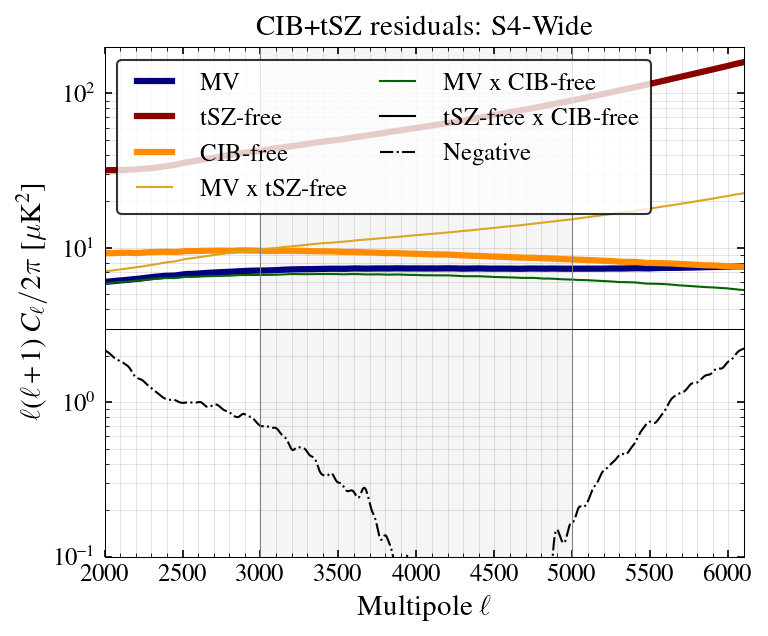

In [168]:
#CIB+tSZ residuals for different ILC estimators w/o  and w/ SPT4/CCAT-prime

reqd_expname = 's4_wide'
reqd_ilc_keyname_dict = {'mv': ['MV', 'navy'], 'tszfree': ['tSZ-free', 'darkred'], 'cibfree': ['CIB-free', 'darkorange'], 
                        'mvxtszfree': ['MV x tSZ-free', 'goldenrod'], 'mvxcibfree': ['MV x CIB-free', 'darkgreen'], 'tszfreexcibfree': ['tSZ-free x CIB-free', 'black']}

'''
colorarr = get_colours( len(reqd_ilc_keyname_dict) )
for cntr, ilc_keyname in enumerate( reqd_ilc_keyname_dict ):
    reqd_ilc_keyname_dict[ilc_keyname][1] = colorarr[cntr]
'''    

#el range
els = ilc_dict['el']

ratio_plot = False #True #False

clf()
totiter=1
if totiter == 2:
    fig=figure(figsize = (10., 5.))
    subplots_adjust(wspace = 0.)
else:
    figure(figsize = (5.5, 4.5))
tc = totiter
fsval = 14
#for pl_iter in range(2):
for pl_iter in range(totiter):

    if ratio_plot:
        ax = subplot(1, tc, pl_iter+1)
    else:
        ax = subplot(1, tc, pl_iter+1, yscale='log')

    if pl_iter == 0:
        for reqd_ilc_keyname in reqd_ilc_keyname_dict:
            reqd_ilc_keyname_str, colorval = reqd_ilc_keyname_dict[reqd_ilc_keyname]
            cib_tsz_ilc_residual = cib_plus_tsz_ilc_residuals_dict[reqd_expname][reqd_ilc_keyname]

            if perform_smoothing:
                cib_tsz_ilc_residual=ndimage.filters.gaussian_filter1d(cib_tsz_ilc_residual,sigma=20)
            else:
                delta_el = 10.
            
            if reqd_ilc_keyname.find('x')>-1:
                lwval = 1.
            else:
                lwval = 3.

            if (1): #take mean for a certain \ell_range
                ##delta_el = 200
                binned_els = np.arange(0, max(els)+100, delta_el)
                binned_dl_fac = binned_els * (binned_els+1)/2/np.pi
                cib_tsz_ilc_residual = np.interp( binned_els, els, cib_tsz_ilc_residual)
                dl_fac = binned_els * (binned_els+1)/2/np.pi #show plot in D_l rather than C_l
                binned_dl_ksz = np.tile(3., len(binned_els))
                cl_ksz = binned_dl_ksz / dl_fac
                els_to_plot = np.copy( binned_els )
            else:
                dl_ksz = np.tile(3., len(els))
                cl_ksz = dl_ksz / dl_fac
                els_to_plot = np.copy( els )


            if ratio_plot:
                plot(els_to_plot, abs(cib_tsz_ilc_residual)/cl_ksz, lw=lwval, color=colorval, ls = '-', label = r'%s' %(reqd_ilc_keyname_str))
            else:
                plot(els_to_plot, dl_fac * cib_tsz_ilc_residual, lw=lwval, color=colorval, ls = '-', label = r'%s' %(reqd_ilc_keyname_str))
                plot(els_to_plot, dl_fac * -cib_tsz_ilc_residual, lw=lwval, color=colorval, ls = '-.')

    #title
    title_str = r'CIB+tSZ residuals: %s' %(exp_specs_dict[reqd_expname][0])
    if pl_iter == 1:
        title_str = r'CIB+tSZ residuals: %s + FYST' %(exp_specs_dict[reqd_expname][0])  
    title(title_str, fontsize = fsval)

    #labels
    #xlabel(r'\textsc{Multipole $\ell$}', fontsize = fsval)
    xlabel(r'Multipole $\ell$', fontsize = fsval)
    fn_format_axis(ax,fsval-2,fsval-2)

    if pl_iter ==0: #legend
        plot([], [], 'k-.', label = r'Negative')
        legend(loc = 2, fontsize = fsval-2, ncol = 2, columnspacing = 1.)#, framealpha=1.)


    #limits
    xmin, xmax = 2000., 4000.
    if (1):
        xmin, xmax = 2000., 6100.
        axvspan(3000., 5000., color = 'whitesmoke')
        axvline(3000., lw = 0.5, color='gray'); axvline(5000., lw = 0.5, color='gray')
    if ratio_plot:
        axhline(1., lw = 2., color = 'lightgray')
        ymin, ymax = 0., 10.
        ylab = r'Ratio: {\rm CIB+tSZ/kSZ}'
    else:
        axhline(3., lw = 0.5)
        ymin, ymax = 0.1, 2e2
        #ylabel(r'\textsc{D$_{\ell}$ [$\mu$K$^{2}$]}', fontsize = fsval)
        #ylab=r'D$_{\ell}$ [$\mu$K$^{2}$]'
        ylab=r'$\ell(\ell+1)\ C_{\ell} / 2\pi$ [$\mu$K$^{2}$]'

    if pl_iter == 0:
        ylabel(ylab, fontsize = fsval)
    else:
        setp(ax.get_yticklabels(), visible=False)        
    xlim(xmin, xmax); ylim(ymin, ymax)

    #grid
    #grid(which = 'major', axis = 'both', lw = 0.1, color = 'black')
    #grid(which = 'minor', axis = 'both', lw = 0.05, color = 'black')
    grid(True, which='both', axis = 'both', lw = 0.5, alpha = 0.1)


#save
plname = 'plots/ilc_cib_plus_tsz_residuals_%s.pdf' %(reqd_expname)
savefig(plname, dpi = 200.)
show()

# Figure 4 of the paper - CIB+tSZ residuals in the cross-ILC tSZ-free x CIB-free estimator for different experiments.

<Figure size 900x600 with 0 Axes>

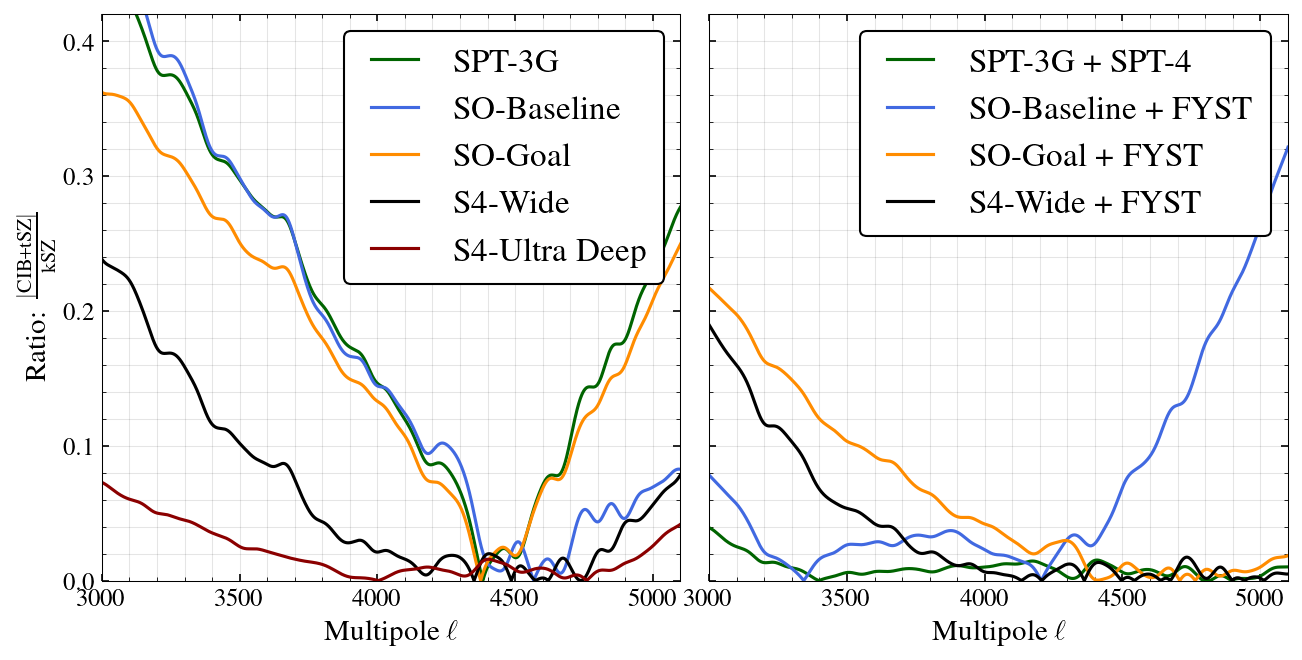

In [161]:
#CIB+tSZ residuals for different ILC estimators w/o  and w/ SPT4/CCAT-prime

#el range
els = ilc_dict['el']
reqd_ilc_keyname = 'tszfreexcibfree'

ratio_plot = True #False #True #False

clf()
totiter=2
if totiter == 2:
    fig=figure(figsize = (10.2, 5.))
    subplots_adjust(wspace = 0.05)
else:
    figure(figsize = (5.5, 4.5))
tc = totiter
fsval = 14
#for pl_iter in range(2):
for pl_iter in range(totiter):

    if ratio_plot:
        ax = subplot(1, tc, pl_iter+1)
    else:
        ax = subplot(1, tc, pl_iter+1, yscale='log')
        
    if pl_iter == 0:
        curr_exparr = ['spt3g', 'so_baseline', 'so_goal', 's4_wide', 's4_deep']
    else:
        curr_exparr = ['spt4', 'so_baseline', 'so_goal', 's4_wide']
 
    for expname in curr_exparr:

        expname_str, colorval = exp_specs_dict[expname]
        cib_tsz_ilc_residual = cib_plus_tsz_ilc_residuals_dict[expname][reqd_ilc_keyname]
        if pl_iter == 1 and expname in ['so_baseline', 'so_goal', 's4_wide']: #replace the config with exp + CCAT-prime
            cib_tsz_ilc_residual = cib_plus_tsz_ilc_residuals_dict_withccatp[expname][reqd_ilc_keyname]
        #cib_tsz_ilc_residual = abs(cib_tsz_ilc_residual)

        if perform_smoothing:
            cib_tsz_ilc_residual=ndimage.filters.gaussian_filter1d(cib_tsz_ilc_residual,sigma=30)
        else:
            delta_el = 10.

        lwval = 1.5

        if (1): #take mean for a certain \ell_range
            #delta_el = 200
            binned_els = np.arange(0, max(els)+100, delta_el)
            binned_dl_fac = binned_els * (binned_els+1)/2/np.pi
            cib_tsz_ilc_residual = np.interp( binned_els, els, cib_tsz_ilc_residual)
            dl_fac = binned_els * (binned_els+1)/2/np.pi #show plot in D_l rather than C_l
            binned_dl_ksz = np.tile(3., len(binned_els))
            cl_ksz = binned_dl_ksz / dl_fac
            els_to_plot = np.copy( binned_els )
        else:
            dl_ksz = np.tile(3., len(els))
            cl_ksz = dl_ksz / dl_fac
            els_to_plot = np.copy( els )

        if pl_iter == 0:
            labval = r'%s' %(expname_str)
        else:
            if expname == 'spt3g' or expname == 'spt4':
                tmp_expname_str, colorval = exp_specs_dict['spt3g']
                labval = r'%s + SPT-4' %(tmp_expname_str)
            else:
                labval = r'%s + FYST' %(expname_str)
        
        if ratio_plot:
            plot(els_to_plot, abs(cib_tsz_ilc_residual)/cl_ksz, lw=lwval, color=colorval, ls = '-', label = labval)
        else:
            plot(els_to_plot, dl_fac * cib_tsz_ilc_residual, lw=lwval, color=colorval, ls = '-', label = labval)
            plot(els_to_plot, dl_fac * -cib_tsz_ilc_residual, lw=lwval, color=colorval, ls = '-.')

    #title
    title_str = r'CIB+tSZ residuals: tSZ-free x CIB-free' 
    #title(title_str, fontsize = fsval)

    #labels
    #xlabel(r'\textsc{Multipole $\ell$}', fontsize = fsval)
    xlabel(r'Multipole $\ell$', fontsize = fsval)
    fn_format_axis(ax,fsval-2,fsval-2)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

    #legend
    #legend(loc = 1, fontsize = fsval-1, ncol = 2, columnspacing = .8, framealpha=1.)
    legend(loc = 1, fontsize = fsval+2, ncol = 1, columnspacing = .8, framealpha=1.)

    #limits
    xmin, xmax = 3000., 5100.
    if ratio_plot:
        axhline(1., lw = 2., color = 'lightgray')
        ymin, ymax = 0., .42
        ylab = r'Ratio: $\frac{|{\rm CIB+tSZ}|}{{\rm kSZ}}$'
    else:
        axhline(3., lw = 0.5)
        ymin, ymax = 0.1, 2e2
        #ylabel(r'\textsc{D$_{\ell}$ [$\mu$K$^{2}$]}', fontsize = fsval)
        ylab=r'D$_{\ell}$ [$\mu$K$^{2}$]'

    if (0):
        xmin, xmax = 1000., 6100.
        axvspan(2000., 5000., color = 'whitesnow')

    if pl_iter == 0:
        ylabel(ylab, fontsize = fsval)
    else:
        setp(ax.get_yticklabels(), visible=False)

    xlim(xmin, xmax); ylim(ymin, ymax)

    #grid
    #grid(which = 'major', axis = 'both', lw = 0.1, color = 'black')
    #grid(which = 'minor', axis = 'both', lw = 0.05, color = 'black')
    grid(True, which='both', axis = 'both', lw = 0.5, alpha = 0.1)


#save
plname = 'plots/ilc_cib_plus_tsz_residuals_crossilc.pdf'
savefig(plname, dpi = 200.)
show()

# Figure 5 - \textsc{Agora} radio residuals in the cross-ILC tSZ-free x CIB-free estimator for S4-Wide. Also shown are the analytic calculations using $\frac{dN}{dS}$ from Lagache and deZotti models.

dict_keys(['dezotti', 'lagache'])
dict_keys(['dezotti', 'lagache'])
dict_keys(['dezotti', 'lagache'])
3000 [-0.45745924]
4000 [-0.81185654]
5000 [-1.07819726]
dict_keys(['dezotti', 'lagache'])
plots/ilc_radio_residuals_s4_wide_tszfreexcibfree.pdf


<Figure size 900x600 with 0 Axes>

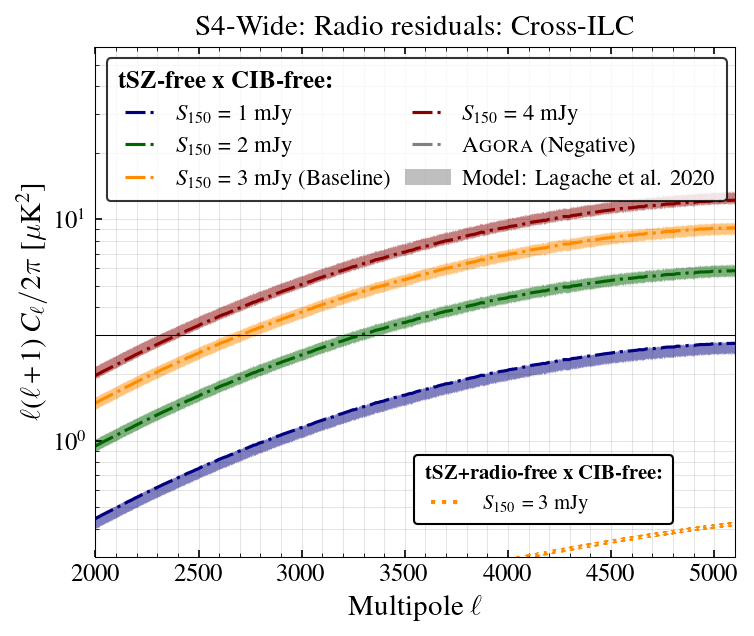

In [155]:
#CIB+tSZ residuals for different ILC estimators w/o  and w/ SPT4/CCAT-prime
add_radio_nulled_with_tsz_ilc = True #False #True

'''
fname = 'publish/data/ilc_weights_residuals_%s_fg_model.npy' %(which_fg_model)
ilc_dict = np.load(fname, allow_pickle = True).item()
radio_ilc_residuals_dict = ilc_dict['radio_residuals']
'''

reqd_expname = 's4_wide'
reqd_ilc_keyname = 'tszfreexcibfree'
reqd_ilc_keyname_str = 'tSZ-free x CIB-free'
'''
if use_radio_nulled_with_tsz_ilc:
    reqd_ilc_keyname = 'tszfreeradiofreexcibfree'
    reqd_ilc_keyname_str = 'tSZ+radio-free x CIB-free'
'''
#colorval = 'black'

#get radio residuals for multiple max flux cuts.
#max_flux_mJy_dict = {1e-3: 'navy', 2e-3: 'darkgreen', 3e-3: 'goldenrod', 4e-3: 'darkred'}
max_flux_mJy_dict = {1e-3: 'navy', 2e-3: 'darkgreen', 3e-3: 'darkorange', 4e-3: 'darkred'}
baseline_max_flux_mJy = 3e-3

#get Agora radio residuals
radio_ilc_residual_agora_fname = 'publish/data/radio_residuals_agora.npy'
parent_radio_ilc_residual_agora_dict = np.load(radio_ilc_residual_agora_fname, allow_pickle=True).item()
#radio_ilc_residual = radio_ilc_residuals_dict[reqd_expname][reqd_ilc_keyname]
spec_inde_scatter_fid = 0.01 #0.2 #maximum intrinsic radio spectral index scatter

#get analytic calculations
anal_radio_res_fname = 'publish/data/radio_residuals_analytic.npy'
parent_anal_radio_res_dict = np.load(anal_radio_res_fname, allow_pickle=True).item()
dn_ds_models_to_use = ['lagache']
dn_ds_specs_dict = {
                    'lagache': [r'Lagache et al. 2020', 'lightskyblue'], 
                    'dezotti': [r'De Zotti et al. 2005', 'darkred'], 
                    }

if add_radio_nulled_with_tsz_ilc:
    radio_ilc_residual_agora_fname_v2 = 'publish/data/radio_residuals_agora_radionulledwithtsz.npy'
    parent_radio_ilc_residual_agora_dict_v2 = np.load(radio_ilc_residual_agora_fname_v2, allow_pickle=True).item()
    ##print(parent_radio_ilc_residual_agora_dict_v2['3.0mJy']['agora'].keys()); sys.exit()

#el range
els = ilc_dict['el']
dl_fac = els * (els+1)/2/np.pi

#plot data
clf()
figure(figsize = (5.5, 4.5))
fsval = 14
lwval = 1.5
ax = subplot(111, yscale='log')
for max_flux_mJy in max_flux_mJy_dict:
    
    max_flux_mJy_keyname = '%smJy' %(max_flux_mJy * 1e3)
    colorval = max_flux_mJy_dict[max_flux_mJy]

    #AGORA residuals for this amx flux cut
    agora_radio_ilc_residual = parent_radio_ilc_residual_agora_dict[max_flux_mJy_keyname]['agora'][spec_inde_scatter_fid]['res_ilc']
    ##agora_radio_ilc_residual = radio_ilc_residuals_dict[reqd_expname][reqd_ilc_keyname]
    el_ = np.arange(len(agora_radio_ilc_residual))
    agora_radio_ilc_residual = np.interp(els, el_, agora_radio_ilc_residual)

    #analytic residuals for this amx flux cut
    anal_radio_res_dict = parent_anal_radio_res_dict[max_flux_mJy_keyname]

    print(anal_radio_res_dict.keys()) #dN/dS used for calculations.
    spec_index_alphaminscatter, spec_index_alphamaxscatter = 0.01, 0.35 #minimum/maximum intrinsic radio spectral index scatter

    if perform_smoothing:
        agora_radio_ilc_residual=ndimage.filters.gaussian_filter1d(agora_radio_ilc_residual,sigma=5)
    else:
        delta_el = 10.
    
    #labval = r'%s (\textsc{Agora})' %(exp_specs_dict[reqd_expname][0])
    labval = r'$S_{150}$ = %g mJy' %(max_flux_mJy * 1e3)
    if max_flux_mJy == baseline_max_flux_mJy:
        labval = r'$S_{150}$ = %g mJy (Baseline)' %(max_flux_mJy * 1e3)
    plot(els, dl_fac * agora_radio_ilc_residual, lw=lwval, color=colorval, ls = '-')#, label = labval)
    plot(els, dl_fac * -agora_radio_ilc_residual, lw=lwval, color=colorval, ls = '-.', label = labval)

    #now overplot analytic residuals
    for dn_ds_keyname_cntr, dn_ds_keyname in enumerate( anal_radio_res_dict ): #analytic residual radio for different spectral inde scatters.
        if dn_ds_keyname not in dn_ds_models_to_use: continue
        analy_radio_cl_alphaminscatter = anal_radio_res_dict[dn_ds_keyname][spec_index_alphaminscatter]['res_ilc']
        analy_radio_cl_alphamaxscatter = anal_radio_res_dict[dn_ds_keyname][spec_index_alphamaxscatter]['res_ilc']
        el_ = np.arange(len(analy_radio_cl_alphaminscatter))
        analy_radio_cl_alphaminscatter = np.interp(els, el_, analy_radio_cl_alphaminscatter)
        analy_radio_cl_alphamaxscatter = np.interp(els, el_, analy_radio_cl_alphamaxscatter)
        minval, maxval = dl_fac * -analy_radio_cl_alphaminscatter, dl_fac * -analy_radio_cl_alphamaxscatter
        labval, colorval_ = dn_ds_specs_dict[dn_ds_keyname]
        labval = r'Model: %s' %(labval)
        fill_between(els, minval, maxval, color = colorval, alpha = 0.5, edgecolor=None)#, label = labval)
    
    if max_flux_mJy == baseline_max_flux_mJy: #print values
        tmp_ell_arr = [3000, 4000, 5000]
        for tmp_ell in tmp_ell_arr:
            tmp_ell_ind = np.where(els == tmp_ell)[0]
            tmp_dl_fac = tmp_ell * (tmp_ell+1)/2/np.pi
            r1, r2 = analy_radio_cl_alphaminscatter[tmp_ell_ind], analy_radio_cl_alphamaxscatter[tmp_ell_ind]
            print(tmp_ell, tmp_dl_fac * (r2-r1))

        if add_radio_nulled_with_tsz_ilc: #add tSZ+radio-free X CIB-free ILC
            agora_radio_ilc_residual_v2 = parent_radio_ilc_residual_agora_dict_v2[max_flux_mJy_keyname]['agora'][0.4]['res_ilc']

            #plot(els, dl_fac * agora_radio_ilc_residual_v2, lw=2., color=colorval, ls = ':')
            plot(els, dl_fac * -agora_radio_ilc_residual_v2, lw=2., color=colorval, ls = ':')
            
#title
if not add_radio_nulled_with_tsz_ilc:
    title_str = r'%s: Radio residuals: %s' %(exp_specs_dict[reqd_expname][0], reqd_ilc_keyname_str)
else:
    title_str = r'%s: Radio residuals: Cross-ILC' %(exp_specs_dict[reqd_expname][0])
title(title_str, fontsize = fsval)

#labels
#xlabel(r'\textsc{Multipole $\ell$}', fontsize = fsval)
xlabel(r'Multipole $\ell$', fontsize = fsval)
fn_format_axis(ax,fsval-2,fsval-2)

labval = r'Model: %s' %(dn_ds_specs_dict[dn_ds_keyname][0])
fill_between([], [], color = 'gray', alpha = 0.5, edgecolor=None, label = labval)
plot([], [], ls='-.', color = 'gray', label = r'\textsc{Agora} (Negative)', lw = lwval)
#plot([], [], 'k-.', label = r'Negative')
if not add_radio_nulled_with_tsz_ilc:
    legend(loc = 2, fontsize = fsval-3., ncol = 2, columnspacing = 0.6, handletextpad = 0.5)#, handlelength = 2.)#, framealpha=1.)
else:
    leg=legend(loc = 2, fontsize = fsval-3., ncol = 2, columnspacing = 0.6, handletextpad = 0.5, title=r'{\bf %s:}' %(reqd_ilc_keyname_str), title_fontsize = fsval-2)#, handlelength = 2.)#, framealpha=1.)
    leg._legend_box.align ='left'
    
#limits
xmin, xmax = 2000., 5100.
axhline(3., lw = 0.5)#, color = 'lightgray')
#ymin, ymax = 0.5, 50.
ymin, ymax = 0.3, 60.
#ylabel(r'\textsc{D$_{\ell}$ [$\mu$K$^{2}$]}', fontsize = fsval)
#ylab=r'D$_{\ell}$ [$\mu$K$^{2}$]'
ylab=r'$\ell(\ell+1)\ C_{\ell} / 2\pi$ [$\mu$K$^{2}$]'

ylabel(ylab, fontsize = fsval)
xlim(xmin, xmax); ylim(ymin, ymax)

#grid
#grid(which = 'major', axis = 'both', lw = 0.1, color = 'black')
#grid(which = 'minor', axis = 'both', lw = 0.05, color = 'black')
grid(True, which='both', axis = 'both', lw = 0.5, alpha = 0.1)

if add_radio_nulled_with_tsz_ilc:
    ax2 = ax.twinx()
    ax2.get_yaxis().set_visible(False)
    colorval = max_flux_mJy_dict[baseline_max_flux_mJy]
    plot([], [], lw=2., color=colorval, ls=':', label = r'$S_{150}$ = %g mJy' %(baseline_max_flux_mJy * 1e3))
    #leg = ax2.legend(loc=1, fontsize = fsval-6, ncol = 1, columnspacing = .8, framealpha=1., title=r'tSZ+radio-free x CIB-free:', title_fontsize = fsval-4)
    leg = ax2.legend(bbox_to_anchor=(0.92, 0.22), fontsize = fsval-4, ncol = 1, columnspacing = .8, framealpha=1., title=r'{\bf tSZ+radio-free x CIB-free:}', title_fontsize = fsval-4)
    leg._legend_box.align ='left'

#save
plname = 'plots/ilc_radio_residuals_%s_%s.pdf' %(reqd_expname, reqd_ilc_keyname)
print(plname)
savefig(plname, dpi = 200.)
show()

# Figure 6 - Lensing bias plot for S4-Wide x $\delta_{g}$ (Overdensity) or $\gamma$ (shear) survey.

0 tsz 1
1 ksz 2
2 cib 3
0 tsz 4
1 ksz 5
2 cib 6
Standard QE $(\ell_{\rm max} = 3000)$: (MV, MV)
Cross-ILC QE $(\ell_{\rm max} = 3000)$: (tSZ-free, CIB-free)
MH18 QE $(\ell_{\rm max} = 3000)$: (tSZ-free, MV)
Cross-ILC QE $(\ell_{\rm max} = 5000)$: (tSZ-free, CIB-free)
plots/lensing_xcorr_biases_s4wide_zbin3.pdf


<Figure size 900x600 with 0 Axes>

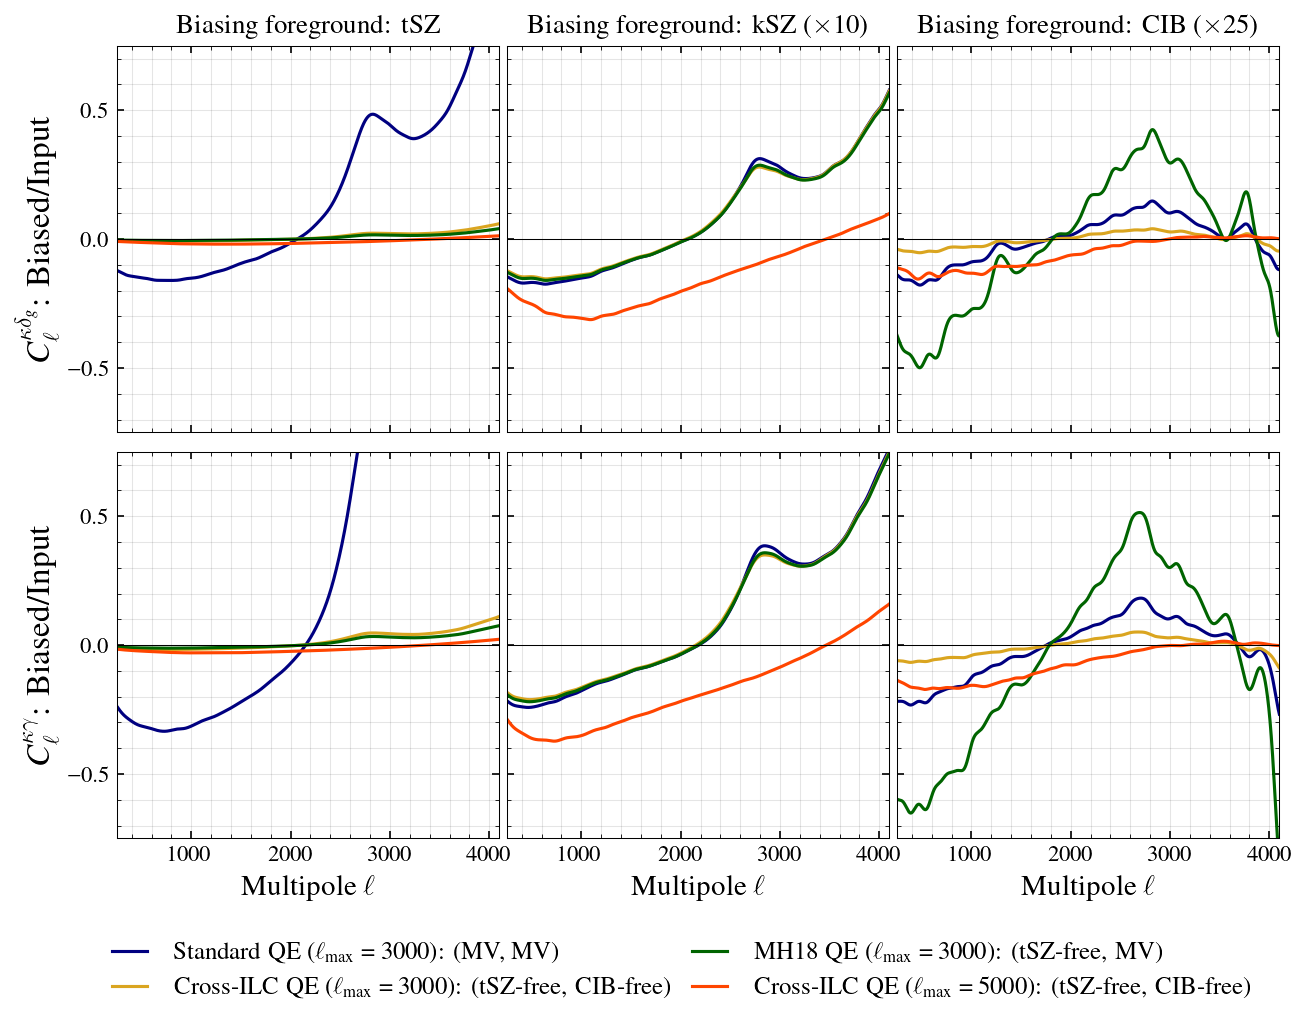

In [158]:
import glob
lensing_parent_folder = 'publish/data/lensing_xls/cmbs4w/' #lensing bias files for S4-Wide.
reqd_zbin = 'zbin3'
fg_component_dict = {'tsz': 'tSZ', 'ksz': 'kSZ', 'cib': 'CIB'}
bias_mul_fac_dict = {'tsz': 1., 'cib': 25., 'ksz': 10.}
cross_corr_component_dict = {'dens': r'\delta_{g}', 'shear': r'\gamma'}
lensing_qe_dict = {'cmbmv': [r'Standard QE $(\ell_{\rm max} = 3000)$: (MV, MV)', 'navy'], 
                   'x': [r'Cross-ILC QE $(\ell_{\rm max} = 3000)$: (tSZ-free, CIB-free)', 'goldenrod'], 
                   'mh_lmaxt3000': [r'MH18 QE $(\ell_{\rm max} = 3000)$: (tSZ-free, MV)', 'darkgreen'], 
                   'x_lmaxt5000': [r'Cross-ILC QE $(\ell_{\rm max} = 5000)$: (tSZ-free, CIB-free)', 'orangered'], 
                   }

clf()
lwval = 1.5
fig=figure(figsize = (10., 7.))
subplots_adjust(wspace=0.02, hspace=0.05)
xmin, xmax = 250., 4100. #4900.
ymin, ymax = -0.75, 0.75
fsval = 14
tr, tc = len(cross_corr_component_dict), len(fg_component_dict)
sbpl = 1
for cross_corr_component_keyname in cross_corr_component_dict: #CMB-kappa x galoverdensity and CMB-kappa x shear
    for fg_cntr, fg_component in enumerate( fg_component_dict ):
        print(fg_cntr, fg_component, sbpl)
        ax = subplot(tr, tc, sbpl)
        
        for lensing_bias_fd in lensing_qe_dict:
            folderpath = '%s/lensrec_%s/' %(lensing_parent_folder, lensing_bias_fd)
            labval, colorval = lensing_qe_dict[lensing_bias_fd]
            #print(folderpath)

            #Input cross-correlation spectrum (Unbiased.)
            fname_unbiased_searchstr = '%s/*_input_%s_%s.dat' %(folderpath, cross_corr_component_keyname, reqd_zbin)
            fname_unbiased = glob.glob( fname_unbiased_searchstr )[0]
            els_lensing, cl_kx_unbiased = np.loadtxt(fname_unbiased, unpack = True) 

            #Output cross-correlation spectrum (Biased by different foregrounds.)
            fname_biased_searchstr = '%s/*_%s_%s_%s.dat' %(folderpath, fg_component, cross_corr_component_keyname, reqd_zbin)
            fname_biased = glob.glob( fname_biased_searchstr )[0]
            els_lensing, cl_kx_biased = np.loadtxt(fname_biased, unpack = True)
            
            curr_ratio = cl_kx_biased/cl_kx_unbiased * bias_mul_fac_dict[fg_component]
            
            if perform_smoothing:
                curr_ratio=ndimage.filters.gaussian_filter1d(curr_ratio,sigma=50)
            else: #bin
                delta_el = 250
                binned_el = np.arange(min(els_lensing), max(els_lensing), delta_el)
                curr_ratio = np.interp( binned_el, els_lensing, curr_ratio)
                els_lensing = binned_el

            #plot
            plot(els_lensing, curr_ratio, color = colorval, lw = lwval)#, label = labval)
            
        axhline(0., lw = 0.5)
        
        #title and xlabel
        title_str = r'Biasing foreground: %s' %(fg_component_dict[fg_component])
        if bias_mul_fac_dict[fg_component]!=1:
            title_str = r'%s ($\times %g$)' %(title_str, bias_mul_fac_dict[fg_component])
            
        if sbpl <=tc:
            title(title_str, fontsize = fsval-1)
            setp(ax.get_xticklabels(), visible=False)   
        else:
            xlabel(r'Multipole $\ell$', fontsize = fsval)

                
        #legend, labels, and axis limits
        if fg_cntr == 0:
            #legend(loc = 1, fontsize = fsval-2)
            ylab = r'{\bf $C_{\ell}^{\kappa %s}$}: Biased/Input' %(cross_corr_component_dict[cross_corr_component_keyname])
            ylabel( ylab, fontsize = fsval+2)
        else:
            setp(ax.get_yticklabels(), visible=False)
        fn_format_axis(ax,fsval-3,fsval-3)
        #ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
        ax.yaxis.set_major_locator(MaxNLocator(nbins=3))
        xlim(xmin, xmax); ylim(ymin, ymax)

        #grid
        #grid(which = 'major', axis = 'both', lw = 0.1, color = 'black')
        #grid(which = 'minor', axis = 'both', lw = 0.05, color = 'black')
        grid(True, which='both', axis = 'both', lw = 0.5, alpha = 0.1)
        
        sbpl += 1
        
if (1): #legend
    xloc, yloc = 0.1, 0.
    w, h = 0.8, 0.05
    cax = fig.add_axes([xloc, yloc, w, h])
    for lensing_bias_fd in lensing_qe_dict:
        labval, colorval = lensing_qe_dict[lensing_bias_fd]
        print(labval)
        plot([], [], color = colorval, label = r'%s' %(labval), lw = lwval)
    legend(loc = 2, fontsize=fsval-2, ncol=2, framealpha = 0., columnspacing=0.5)
    axis('off')    
#save
plname = 'plots/lensing_xcorr_biases_s4wide_%s.pdf' %(reqd_zbin)
print(plname)
savefig(plname, dpi = 200.)
show()

# Figure A.1 of the paper - Compare \textsc{Agora} ILC residuals for S4-Wide but using weights calculated using SPT and \textsc{Agora} foreground models.

dict_keys(['weights', 'total_ilc_residuals', 'cib_plus_tsz_residuals', 'cib_residuals', 'tsz_residuals', 'noise_residuals', 'radio_residuals', 'nl_TP_dict', 'cl_signal_plus_noise', 'ilc_keyname_arr', 'el'])
dict_keys(['weights', 'total_ilc_residuals', 'cib_plus_tsz_residuals', 'cib_residuals', 'tsz_residuals', 'cl_signal_plus_noise', 'ilc_keyname_arr', 'el'])


<Figure size 900x600 with 0 Axes>

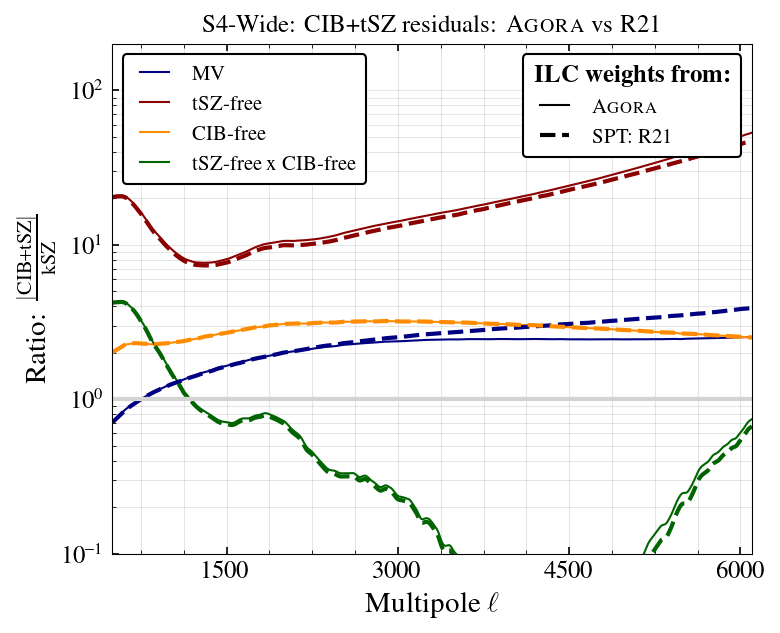

In [160]:
#read file
#which_fg_model_dict = {'agora': [r'\textsc{Agora}', '-', 1.], 'spt': [r'SPT: Reichardt et al. 2021', ':', 2.]}
which_fg_model_dict = {'agora': [r'\textsc{Agora}', '-', 1.], 'spt': [r'SPT: R21', '--', 2.]}
reqd_expname = 's4_wide'
reqd_ilc_keyname_dict = {'mv': ['MV', 'navy'], 'tszfree': ['tSZ-free', 'darkred'], 'cibfree': ['CIB-free', 'darkorange'], 
                        'tszfreexcibfree': ['tSZ-free x CIB-free', 'darkgreen']}

ratio_plot = True #False
clf()
figure(figsize = (5.5, 4.5))
fsval = 14
ax = subplot(111, yscale='log')
for which_fg_model_cntr, which_fg_model in enumerate( which_fg_model_dict ):
    fname = 'publish/data/ilc_weights_residuals_%s_fg_model.npy' %(which_fg_model)
    ilc_dict = np.load(fname, allow_pickle = True).item()
    print(ilc_dict.keys())

    #el range
    els = ilc_dict['el']
    dl_fac = els * (els+1)/2/np.pi
    
    for reqd_ilc_keyname in reqd_ilc_keyname_dict:
    
        #CIB, tSZ, and CIB+tSZ
        cib_tsz_ilc_residual = ilc_dict['cib_plus_tsz_residuals'][reqd_expname][reqd_ilc_keyname]

        if perform_smoothing:
            cib_tsz_ilc_residual=ndimage.filters.gaussian_filter1d(cib_tsz_ilc_residual,sigma=25)
        else:
            delta_el = 10.
        
        if (1): #take mean for a certain \ell_range
            ##delta_el = 200
            binned_els = np.arange(0, max(els)+100, delta_el)
            binned_dl_fac = binned_els * (binned_els+1)/2/np.pi
            cib_tsz_ilc_residual = np.interp( binned_els, els, cib_tsz_ilc_residual)
            dl_fac = binned_els * (binned_els+1)/2/np.pi #show plot in D_l rather than C_l
            binned_dl_ksz = np.tile(3., len(binned_els))
            cl_ksz = binned_dl_ksz / dl_fac
            els_to_plot = np.copy( binned_els )
        else:
            dl_ksz = np.tile(3., len(els))
            cl_ksz = dl_ksz / dl_fac
            els_to_plot = np.copy( els )

        labval, colorval = reqd_ilc_keyname_dict[reqd_ilc_keyname]
        which_fg_model_str, lsval, lwval = which_fg_model_dict[which_fg_model]
        if which_fg_model == 'spt':
            labval = None
        if ratio_plot:
            plot(els_to_plot, abs(cib_tsz_ilc_residual)/cl_ksz, lw=lwval, color=colorval, ls = lsval, label = labval)
        else:
            plot(els_to_plot, dl_fac * abs(cib_tsz_ilc_residual), lw=lwval, color=colorval, ls = lsval, label = labval)


#title
title_str = r'%s: CIB+tSZ residuals: \textsc{Agora} vs R21' %(exp_specs_dict[reqd_expname][0])
title(title_str, fontsize = fsval-2)

#labels
#xlabel(r'\textsc{Multipole $\ell$}', fontsize = fsval)
xlabel(r'Multipole $\ell$', fontsize = fsval)
fn_format_axis(ax,fsval-2,fsval-2)
ax.xaxis.set_major_locator(MaxNLocator(nbins=4))
#ax.yaxis.set_major_locator(MaxNLocator(nbins=3))

#legend
legend(loc = 2, fontsize = fsval-4, ncol = 1, columnspacing = .8, framealpha=1.)


#limits
xmin, xmax = 3000., 4900.
xmin, xmax = 500., 6100.
ymin, ymax = 0., .5
if ratio_plot:
    axhline(1., lw = 2., color = 'lightgray')
    ymin, ymax = 0.1, 200.
    ylab = r'Ratio: $\frac{|{\rm CIB+tSZ}|}{{\rm kSZ}}$'
else:
    axhline(3., lw = 0.5)
    ymin, ymax = 0.1, 3e2
    #ylabel(r'\textsc{D$_{\ell}$ [$\mu$K$^{2}$]}', fontsize = fsval)
    ylab=r'$\ell(\ell+1)\ |C_{\ell}| / 2\pi$ [$\mu$K$^{2}$]'
ylabel(ylab, fontsize = fsval)
xlim(xmin, xmax); ylim(ymin, ymax)

#grid
grid(True, which='both', axis = 'both', lw = 0.5, alpha = 0.1)

ax2 = ax.twinx()
for which_fg_model_cntr, which_fg_model in enumerate( which_fg_model_dict ):
    which_fg_model_str, lsval, lwval = which_fg_model_dict[which_fg_model]
    plot([], [], color='black', ls=lsval, lw=lwval, label = which_fg_model_str)
ax2.get_yaxis().set_visible(False)
leg = ax2.legend(loc=1, fontsize = fsval-4, ncol = 1, columnspacing = .8, framealpha=1., title=r'{\bf ILC weights from:}', title_fontsize = fsval-2)
leg._legend_box.align ='left'

#save
plname = 'plots/ilc_cib_plus_tsz_residuals_agora_vs_spt.pdf'
savefig(plname, dpi = 200.)
show()

dict_keys(['weights', 'total_ilc_residuals', 'cib_plus_tsz_residuals', 'cib_residuals', 'tsz_residuals', 'cl_signal_plus_noise', 'ilc_keyname_arr', 'el'])
dict_keys(['s4_wide', 'spt3g', 'spt4', 'so_baseline', 'so_goal'])
(4, 7000)
[0.         0.         0.4946449  ... 0.1303287  0.12998885 0.1304144 ]
[0.         0.         0.41924553 ... 0.84912311 0.84910329 0.8499596 ]
[0.         0.         0.07395485 ... 0.07920059 0.07942964 0.07864019]
[ 0.          0.          0.01215472 ... -0.0586524  -0.05852178
 -0.05901419]


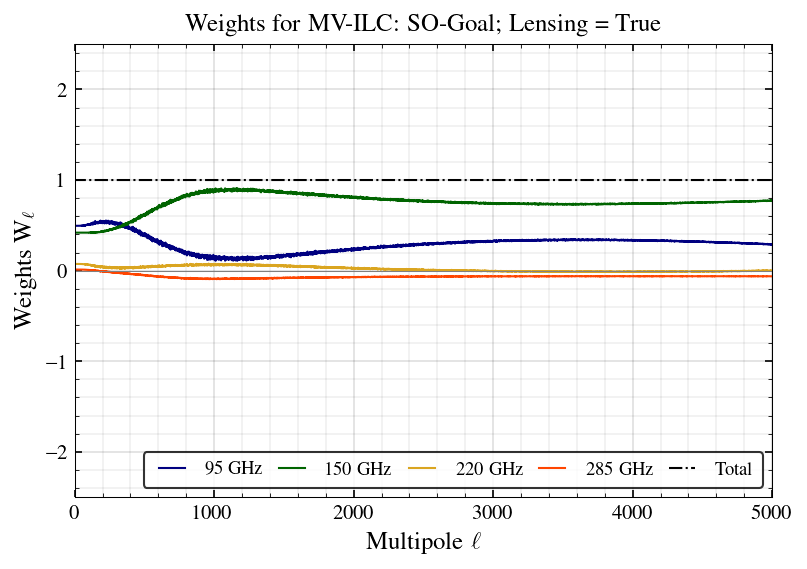

In [169]:
#read and show weights
which_fg_model = 'agora'
reqd_ilc_keyname = 'mv'
#reqd_expname = 's4_wide'
#reqd_ilc_keyname = 'tszfree'
#reqd_ilc_keyname = 'cibfree'
reqd_expname = 'so_goal'
#reqd_expname = 'so_baseline'
#reqd_expname = 'spt3g'

for_lensing = True
if for_lensing:
    fname = 'publish/data/ilc_weights_residuals_%s_fg_model_forlensing.npy' %(which_fg_model)
else:
    fname = 'publish/data/ilc_weights_residuals_%s_fg_model.npy' %(which_fg_model)
ilc_dict = np.load(fname, allow_pickle = True).item()
print(ilc_dict.keys())

#different types of ILC considered
ilc_keyname_arr = ilc_dict['ilc_keyname_arr']
#print(ilc_keyname_arr)

#ILC weights
weights_dict = ilc_dict['weights']
print(weights_dict.keys())
#el range
els = ilc_dict['el']

assert reqd_ilc_keyname in ilc_keyname_arr
assert reqd_expname in list( exp_specs_dict.keys() )

#frequency bands
if reqd_expname in ['s4_wide', 's4_deep', 'so_baseline', 'so_goal']:
    nu_arr = [95, 150, 220, 285]
elif reqd_expname == 'spt3g':
    nu_arr = [95, 150, 220]#, 600, 857]
elif reqd_expname == 'spt4':
    nu_arr = [95, 150, 220, 285, 345]
band_color_dict = {95: 'navy', 150: 'darkgreen', 220: 'goldenrod', 285: 'orangered', 345: 'darkred'}

#N_band x lmax array
weights_arr = weights_dict[reqd_expname][reqd_ilc_keyname]

#save weights
'''
if reqd_ilc_keyname == 'tszfree':
    np.save('so_goal_weights_ynull.npy', weights_arr)
elif reqd_ilc_keyname == 'cibfree':
    np.save('so_goal_weights_cibnull.npy', weights_arr)
'''
opfname = 'publish/data/%s_weights_%s' %(reqd_expname, reqd_ilc_keyname)
if for_lensing:
    opfname = '%s_forlensing' %(opfname)
opfname = '%s.npy' %(opfname)
np.save(opfname, weights_arr)
print(weights_arr.shape)

#plot weights
fsval = 12
ax = subplot(111)

for w, nu in zip(weights_arr, nu_arr):
    print(w)
    plot(els, w, color = band_color_dict[nu], label = r'%s GHz' %(nu))

weights_sum = np.sum(weights_arr, axis = 0)
plot(els, weights_sum, color = 'black', ls = '-.', label = r'Total')
axhline(0., lw=0.5, color = 'gray')

#title
title_str = r'Weights for %s-ILC: %s; Lensing = %s' %(ilc_keyname_dict[reqd_ilc_keyname], exp_specs_dict[reqd_expname][0], for_lensing)
title(title_str, fontsize = fsval)

#legend
legend(loc = 4, fontsize = fsval-3, ncol = 5, columnspacing=0.5)

#labels
xlabel(r'Multipole $\ell$', fontsize = fsval)
ylabel(r'Weights W$_{\ell}$', fontsize = fsval)

#limits
xmin, xmax = 0, 5000.
#ymin, ymax = -1.2, 1.2
ymin, ymax = -2.5, 2.5
xlim(xmin, xmax); ylim(ymin, ymax)

#grid
grid(which = 'major', axis = 'both', lw = 0.1, color = 'black')
grid(which = 'minor', axis = 'both', lw = 0.05, color = 'black')

#save
plname = 'plots/ilc_weights_%s_%s' %(reqd_ilc_keyname, reqd_expname)
if for_lensing:
    planme = '%s_forlensing' %(plname)
plname = '%s.png' %(plname)
#savefig(plname, dpi = 200.)
show()